# Importar librerías y módulos

In [1]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from gcn_model import GCN
from Dataset_loader import (
    prepare_dataset, load_dataset, load_pcb_dataset,
    standardize_data, denormalize_graphs,
    target_mean, target_std, PCBDataset
)
from train_eval import train, evaluate, predict, plot_temperature_maps
from model_saver import save_model


In [2]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Configuración reproducible
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Usando dispositivo: cuda


## Configuración

In [3]:
config = {
    "file_path": "PCB_dataset.pth",
    "apply_standardization": True,
    "use_percentage_threshold": False,
    "error_threshold_K": 5.0,
    "percentage_threshold": 5.0,
    "batch_size": 32,
    "input_dim": 1,
    "hidden_dim": 64,
    "output_dim": 1,
    "num_layers": 2,
    "learning_rate": 0.001,
    "epochs": 3,
    "keep_best_model_in_memory": False,
    "use_dropout": True,
    "dropout_rate": 0.2,
    "use_batchnorm": True,
    "use_residual": True
}


In [4]:
# Cargar dataset desde archivo
graphs = load_pcb_dataset(config["file_path"], device=device)

# Estandarizar si es necesario
if config["apply_standardization"]:
    graphs = standardize_data(graphs, device=device)


print(f"Dataset cargado correctamente. Número de gráficos: {len(graphs)}")
nodos_por_grafico = graphs[0].y.shape[0]
print(f"Nodos por gráfico: {nodos_por_grafico}")


c:\Users\ramse\Escritorio\Aero Ordenador\4to Aero\2do Cuatri\Repo_TFG\ia_thermal\ernestoemedina\Opt_GCN_1\Dataset_loader.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Dataset estandarizado (mean=354.61, std=35.92)
Dataset cargado correctamente. Número de gráficos: 20000
Nodos por gráfico: 169


In [5]:
# División del dataset
train_size = int(0.8 * len(graphs))
val_size = int(0.1 * len(graphs))
test_size = len(graphs) - train_size - val_size

train_dataset = graphs[:train_size]
val_dataset = graphs[train_size:train_size + val_size]
test_dataset = graphs[train_size + val_size:]

# Crear DataLoaders
batch_size = config["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Modelo

In [6]:
# Crear el modelo

model = GCN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
best_model_state = None
#best_val_loss = float("inf")
min_loss = float("inf")
print("Modelo inicializado correctamente.")

Modelo inicializado correctamente.


## Entrenamiento

In [7]:
print("Iniciando entrenamiento...")

for epoch in range(config["epochs"]):
    train_loss = train(model, train_loader, optimizer, device, normalize=config["apply_standardization"])

    val_mse, val_mae, val_r2, val_accuracy = evaluate(
    model, val_loader, device,
    nodos_por_grafico=nodos_por_grafico,
    error_threshold=config["error_threshold_K"],
    percentage_threshold=config["percentage_threshold"] if config["use_percentage_threshold"] else None,
    plot_results=False,
    normalize=config["apply_standardization"],
)

    print(f"Epoch {epoch+1}/{config['epochs']} - Loss: {train_loss:.4f} - Val MSE: {val_mse:.4f} - Val MAE: {val_mae:.4f} - Val R2: {val_r2:.4f} - Val Accuracy: {val_accuracy:.2f}%")

    if config["keep_best_model_in_memory"] and train_loss < min_loss:
        min_loss = train_loss
        best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
        print(f"Nuevo mejor modelo encontrado en el epoch {epoch+1}")

Iniciando entrenamiento...
Epoch 1/3 - Loss: 22.9208 - Val MSE: 78.6486 - Val MAE: 8.7522 - Val R2: -121.0700 - Val Accuracy: 0.00%
Epoch 2/3 - Loss: 1.1043 - Val MSE: 99.8583 - Val MAE: 9.9035 - Val R2: -155.5106 - Val Accuracy: 0.00%
Epoch 3/3 - Loss: 0.9174 - Val MSE: 97.9336 - Val MAE: 9.8149 - Val R2: -152.6660 - Val Accuracy: 0.00%


## Evaluación

Evaluando en el conjunto de prueba...


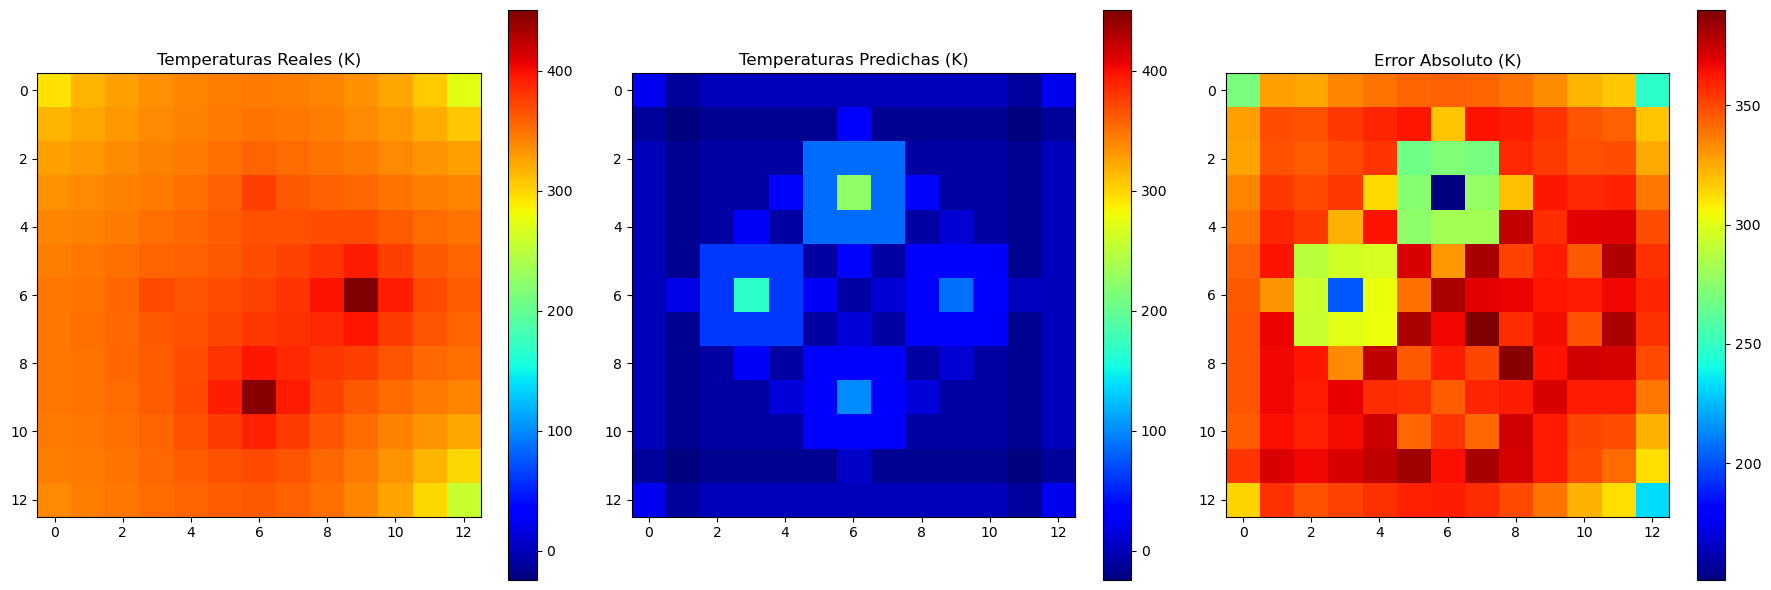

Test MSE: 126485.9219 | MAE: 352.7710 | R2: -154.9353
% de nodos dentro de ±5.0K: 0.00%


In [8]:
print("Evaluando en el conjunto de prueba...")

if config["keep_best_model_in_memory"] and best_model_state is not None:
    model.load_state_dict(best_model_state)

test_mse, test_mae, test_r2, test_accuracy = evaluate(
    model, test_loader, device,
    nodos_por_grafico=nodos_por_grafico,
    error_threshold=config["error_threshold_K"],
    percentage_threshold=config["percentage_threshold"] if config["use_percentage_threshold"] else None,
    plot_results=True,
    normalize=False
)

print(f"Test MSE: {test_mse:.4f} | MAE: {test_mae:.4f} | R2: {test_r2:.4f}")
if config["use_percentage_threshold"]:
    print(f"% de nodos dentro de ±{config['percentage_threshold']}%: {test_accuracy:.2f}%")
else:
    print(f"% de nodos dentro de ±{config['error_threshold_K']}K: {test_accuracy:.2f}%")


In [9]:
# Guardar modelo solo si se usó memoria
if config["keep_best_model_in_memory"]:
    save_model(
        model,
        num_layers=config["num_layers"],
        hidden_dim=config["hidden_dim"],
        epochs=config["epochs"],
        learning_rate=config["learning_rate"],
        test_mse=test_mse,
        test_accuracy=test_accuracy,
        best_model_state=best_model_state,
        save_best_model_to_file=True
    )
